# 프로젝트: 인물 모드 문제점 찾기

⭐️ 인물모드 사진을 성공적으로 제작하였다. 아웃포커싱 효과가 적용된 인물모드 사진과 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.  
⭐️ 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다. 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.  
⭐️ 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다. semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시하였다.  

### 🎉 Import libraries & packages

In [1]:
# import useful tools
import os       # get system environment variables
import urllib   # URL tools


# import data tools
import numpy as np


# import visual tools
from matplotlib import pyplot as plt


# import image processing tools
import cv2                                             # computer vision tools
from pixellib.semantic import semantic_segmentation    # semantic segmentation model

### 🎉 Define constants

In [2]:
# number of total images
TOTAL_BACKGROUNDS = 1
TOTAL_TEST_IMAGES = 4

# blur kernel size
BLUR_SIZE = 13

# figure display size 
DISPLAY_SIZE = 16

# directory path of image files
img_path = os.getenv("HOME") + "/aiffel/human_segmentation/images/"

### 🎉 Download & generate PixelLib segmentation model

In [3]:
# set path & file name to save segmentation model
model_path = model_path = os.getenv("HOME") + "/aiffel/human_segmentation/models/"
model_filename = os.path.join(model_path, "deeplabv3_xception_tf_dim_ordering_tf_kernels.h5")

# get url of segmentation model
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# download segmentation model from url, and save as file
urllib.request.urlretrieve(model_url, model_filename)


# generate instance of PixelLib segmentation model class
model = semantic_segmentation()

# initialize the model with "pascal voc" algorithm model
model.load_pascalvoc_model(model_filename)

### 🎉 Define color map & a method to get color of specific objects

In [4]:
# define label names in order  of seg pascalvoc
LABEL_NAMES = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
                "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
                "person", "pottedplant", "sheep", "sofa", "train", "tv" ]

LABEL_DICT = {LABEL_NAMES[index]: index for index in range(len(LABEL_NAMES))}



# define colormap
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

    
    
# get color of specific objects by name
def getColor(label):
    blue, green, red = colormap[LABEL_DICT[label]]
    return (red, green, blue)

### 🎉 Define segmentation & background merge methods

In [5]:
def segmentImage(img_filename, object_name):
    # detect & segment objects from image
    segmented_val, img_segmented = model.segmentAsPascalvoc(img_filename)
    
    # split background & specific objects from image
    img_bg_split = np.all(img_segmented == getColor(object_name), axis = -1)

    return img_segmented, img_bg_split



def mergeObjectBackground(img, img_segmented, img_bg_split, blur = True):
    # blur == True  : 기존 이미지의 배경 부분을 blur 
    # blur == False : 새로운 배경 이미지를 합성
    
    
    # get blurred image (기존 이미지를 blur 처리하여 배경 이미지 img_bg 준비)
    if blur == True:
        img_bg = cv2.blur(img.copy(), (BLUR_SIZE, BLUR_SIZE))
    
    # load background image (배경 그림 파일을 불러와서 배경 이미지 img_bg 준비)
    else:
        # load background image
        bg_path = os.getenv("HOME") + "/aiffel/human_segmentation/images/"
        img_bg = cv2.cvtColor(cv2.imread(bg_path + "background1.png"), cv2.COLOR_BGR2RGB)
        
        # get size of object/background image
        img_size = img.shape
        img_bg_size = img_bg.shape
        
        # resize the background imamge
        if img_size[0] > img_bg_size[0] or img_size[1] > img_bg_size[1]:
            scale = max(img_size[0] / img_bg_size[0], img_size[1] / img_bg_size[1]) + 0.1
            img_bg = cv2.resize(img_bg, None, fx = scale, fy = scale, interpolation = cv2.INTER_LINEAR)
            img_bg_size = img_bg.shape
        
        # crop the backgorund image
        if img_size[0] <= img_bg_size[0] and img_size[1] <= img_bg_size[1]:
            h_start = (img_bg_size[0] - img_size[0]) // 2
            h_end = h_start + img_size[0]
            v_start = (img_bg_size[1] - img_size[1]) // 2
            v_end = v_start + img_size[1]
            img_bg = img_bg[h_start:h_end, v_start:v_end]
    
    
    # create mask to filter background/person
    img_mask = img_bg_split.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # reverse image color (background 0, person 255 -> background 255, person 0)
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # set all pixels at person zone 0
    img_bg_result = cv2.bitwise_and(img_bg, img_bg_mask)

    # merge original image (object) & background image 
    img_object = img.copy()
    img_merged = np.where(img_mask_color == 255, img_object, img_bg_result)
    
    
    return img_bg_result, img_merged



# display 7 images in 4*2 layout
def display8(img, img_segmented, img_bg_split, img_bg_mask1, img_merged1, img_bg_mask2, img_merged2, object_name):
    fig = plt.figure(figsize = (DISPLAY_SIZE, DISPLAY_SIZE))
    
    subplot1 = fig.add_subplot(4, 2, 1)
    subplot1.imshow(img)
    subplot1.set_title("original")
    subplot1.axis("off")
    
    subplot2 = fig.add_subplot(4, 2, 3)
    subplot2.imshow(img_segmented)
    subplot2.set_title("object segmented")
    subplot2.axis("off")
    
    subplot3 = fig.add_subplot(4, 2, 4)
    subplot3.imshow(img_bg_split, cmap = "gray")    #  해당 오브젝트 이외의 위치는 "gray" 색상으로 출력
    subplot3.set_title(object_name + " & background split")
    subplot3.axis("off")
    
    subplot4 = fig.add_subplot(4, 2, 5)
    subplot4.imshow(img_bg_mask1)
    subplot4.set_title("background mask (blur)")
    subplot4.axis("off")
    
    subplot5 = fig.add_subplot(4, 2, 6)
    subplot5.imshow(img_merged1)
    subplot5.set_title("result (blur)")
    subplot5.axis("off")
    
    subplot6 = fig.add_subplot(4, 2, 7)
    subplot6.imshow(img_bg_mask2)
    subplot6.set_title("background mask (flowered)")
    subplot6.axis("off")
    
    subplot7 = fig.add_subplot(4, 2, 8)
    subplot7.imshow(img_merged2)
    subplot7.set_title("result (flowered)")
    subplot7.axis("off")
    
    plt.tight_layout()
    plt.show()

### 🎉 Load image data

In [6]:
# indicate the directory path of image files
img_path = os.getenv("HOME") + "/aiffel/human_segmentation/images/"

# load test image data
test_img = {"filename" : [], "img_bgr" : [], "img_rgb" : [], "img_blurred" : [], "img_flowered" : []}
for i in range(1, TOTAL_TEST_IMAGES + 1):
    # indicate file name
    filename = img_path + "image" + str(i) + ".png"
    test_img["filename"].append(filename)
    
    # load image file
    test_img["img_bgr"].append(cv2.imread(filename))
    
    # convert color mode (BGR -> RGB)
    test_img["img_rgb"].append(cv2.cvtColor(test_img["img_bgr"][-1], cv2.COLOR_BGR2RGB))


    
# load background image data (to test merge background & object)
background_img = {"filename" : [], "img_bgr" : [], "img_rgb" : []}
for i in range(1, TOTAL_BACKGROUNDS + 1):
    # indicate file name
    filename = img_path + "background" + str(i) + ".png"
    background_img["filename"].append(filename)
    
    # load image file
    background_img["img_bgr"].append(cv2.imread(filename))
    
    # convert color mode (BGR -> RGB)
    background_img["img_rgb"].append(cv2.cvtColor(background_img["img_bgr"][-1], cv2.COLOR_BGR2RGB))

### 🎉 Test segmentation & background merge

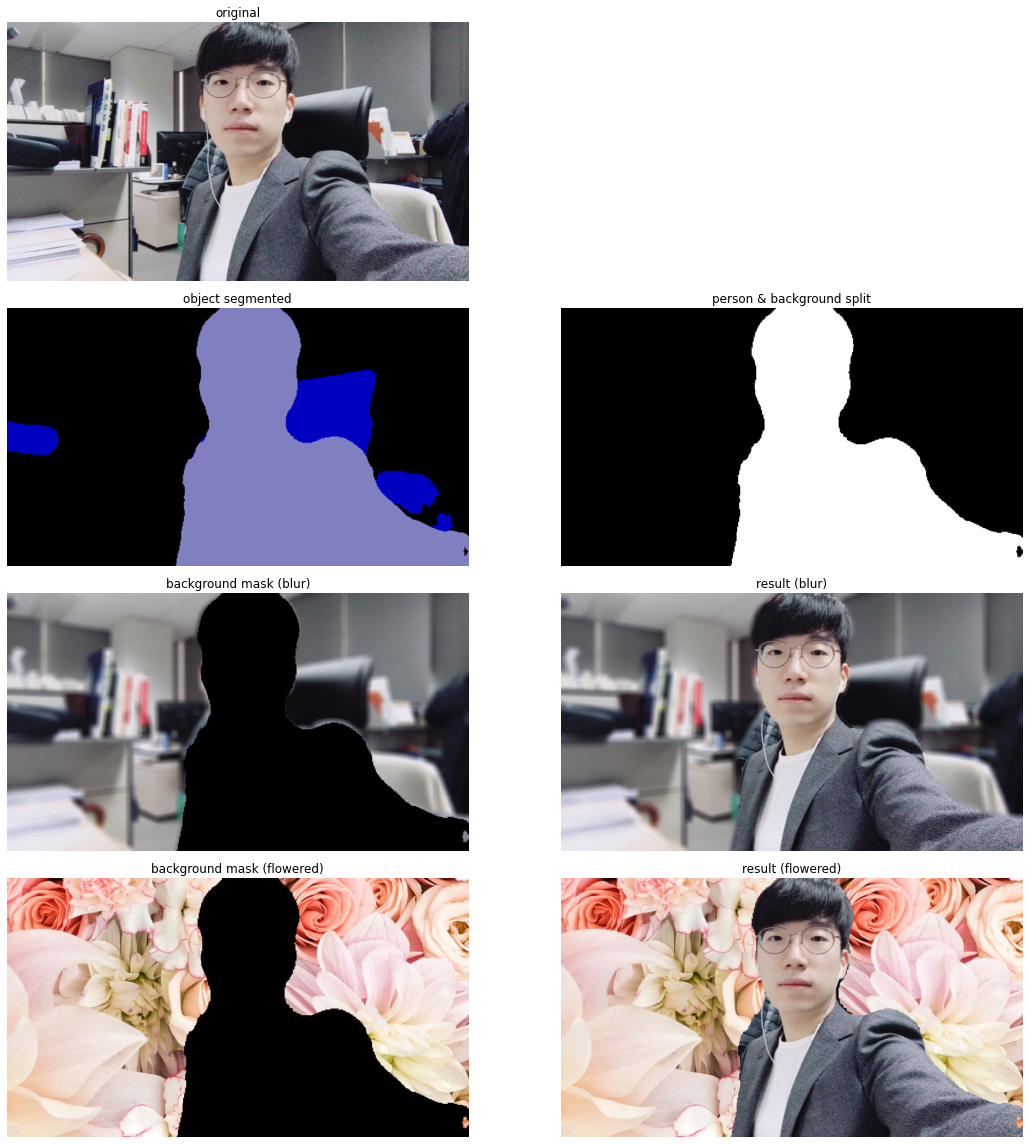

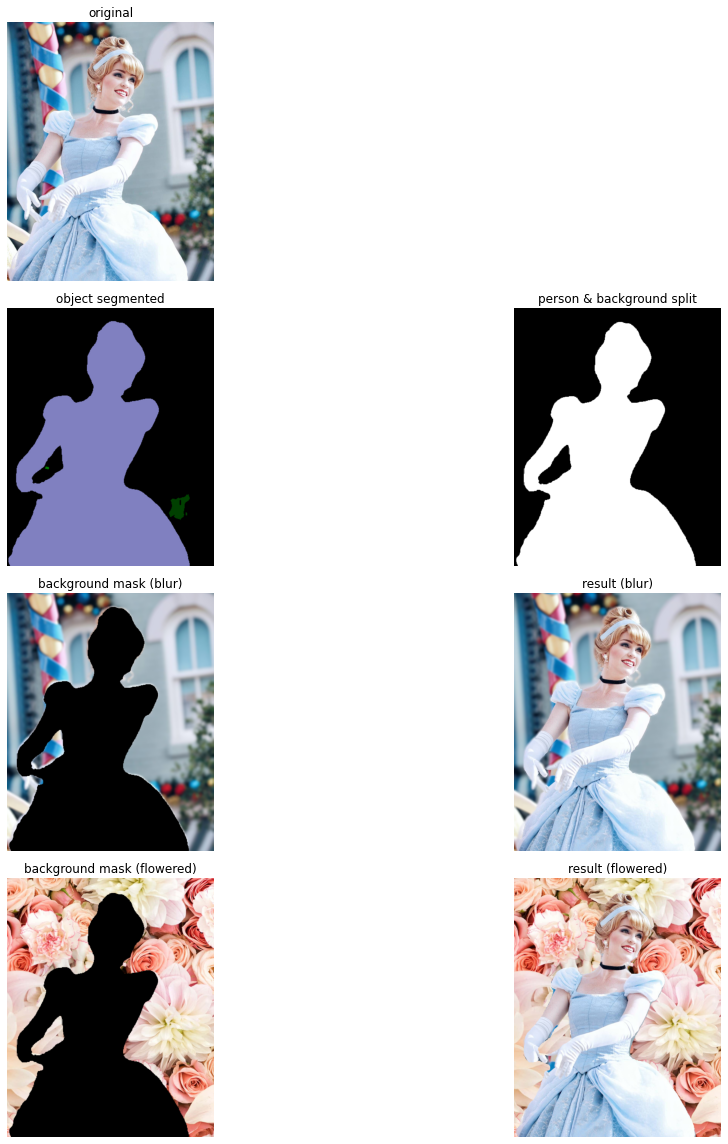

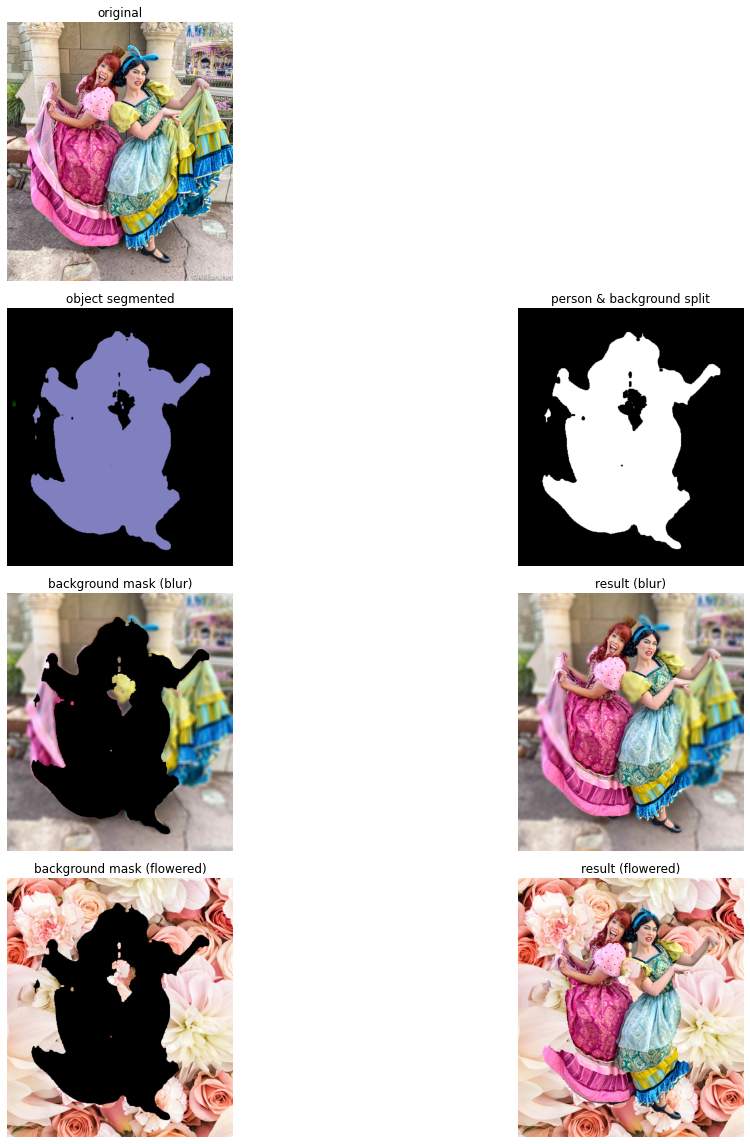

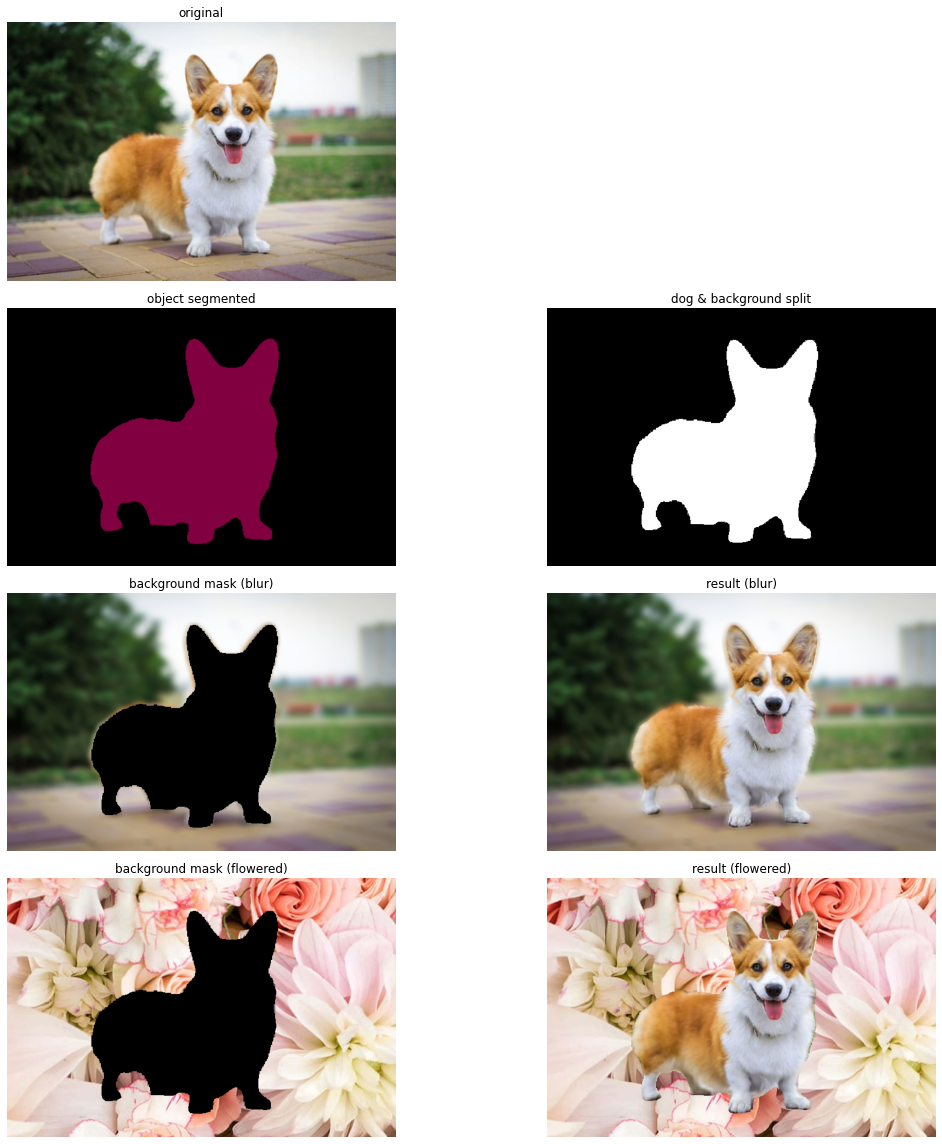

In [7]:
for i in range(TOTAL_TEST_IMAGES):
    # load image
    img = test_img["img_rgb"][i]
    
    # set object type to process segmentation 
    object_name = "person"
    if i == 3:    # segment "dog" from "image3.png"
        object_name = "dog"
    
    # process segmentation
    img_segmented, img_bg_split = segmentImage(test_img["filename"][i], object_name)
    
    # merge blurred background
    img_bg_result1, img_merged1 = mergeObjectBackground(img, img_segmented, img_bg_split, blur = True)
    
    # merge flowered background
    img_bg_result2, img_merged2 = mergeObjectBackground(img, img_segmented, img_bg_split, blur = False)
    
    # display resulting images
    display8(img, img_segmented, img_bg_split, img_bg_result1, img_merged1, img_bg_result2, img_merged2, object_name)
    
    # save resulting images
    test_img["img_blurred"].append(img_merged1)
    test_img["img_flowered"].append(img_merged2)

### 🎉 Define text insertion methods

In [8]:
# put text(caption) in image
# 기존 cv2의 putText() 함수와 혼용을 방지하기 위해 함수명을 putCaption()으로 정의
def putCaption(img, caption, pos1, pos2):
    # mark circle
    img_captioned = cv2.putText(img.copy(), "o",
                                org = pos1,
                                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                                fontScale = 12,
                                color = (255, 0, 0),
                                thickness = 12)
    
    # put caption text
    img_captioned = cv2.putText(img_captioned, caption,
                                org = pos2,
                                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                                fontScale = 2,
                                color = (255, 0, 0),
                                thickness = 5)
    
    return img_captioned



# display 2 images in 1*2 layout
def display2(img, img_merged, img_captioned):
    fig = plt.figure(figsize = (DISPLAY_SIZE, DISPLAY_SIZE))
    
    subplot1 = fig.add_subplot(1, 2, 1)
    subplot1.imshow(img)
    subplot1.set_title("original")
    subplot1.axis("off")
    
    subplot2 = fig.add_subplot(1, 2, 2)
    subplot2.imshow(img_captioned)
    subplot2.set_title("problem found")
    subplot2.axis("off")
    
    plt.tight_layout()
    plt.show()

### 🎉 Put text in images to suggest limitations

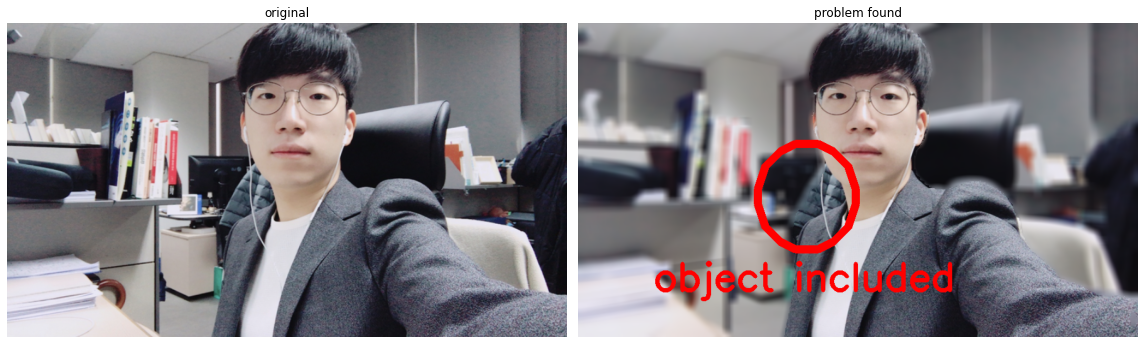

In [9]:
# problem in experiment with "image1.png"
img_original = test_img["img_rgb"][0]
img_merged = test_img["img_blurred"][0]
img_captioned = putCaption(img_merged, "object included", (250, 360), (120, 425))
    
display2(img_original, img_merged, img_captioned)

**문 제 점** : 어깨 뒷부분에 배경 물체(옷)가 사람으로 동일하게 인식되었다. 아마 특별한 자세에 의한 어깨의 연장선이라고 인식하거나, 머리카락이 긴 사람이라고 인식된 것이 아닐까 생각한다.  
**해결방안** : 잘못 인식된 물체가 얼굴, 자켓과의 경계와 서로 다른 색상을 지니고 있으므로, 유사한 색상을 기준으로 오브젝트 경계를 판단했으면 해결할 수 있었을까 생각이 든다. 다만 이러한 알고리즘이 해당 사진에는 정상적으로 작동할지라도, 사람은 다양한 자세와 패션 스타일을 가질 수 있기 때문에, 즉 사람이라는 오브젝트 내에 다양한 색상을 포함하는 가능성이 열려있기 때문에, 모든 상황에 원활하게 대응하지는 못할 것이다. 

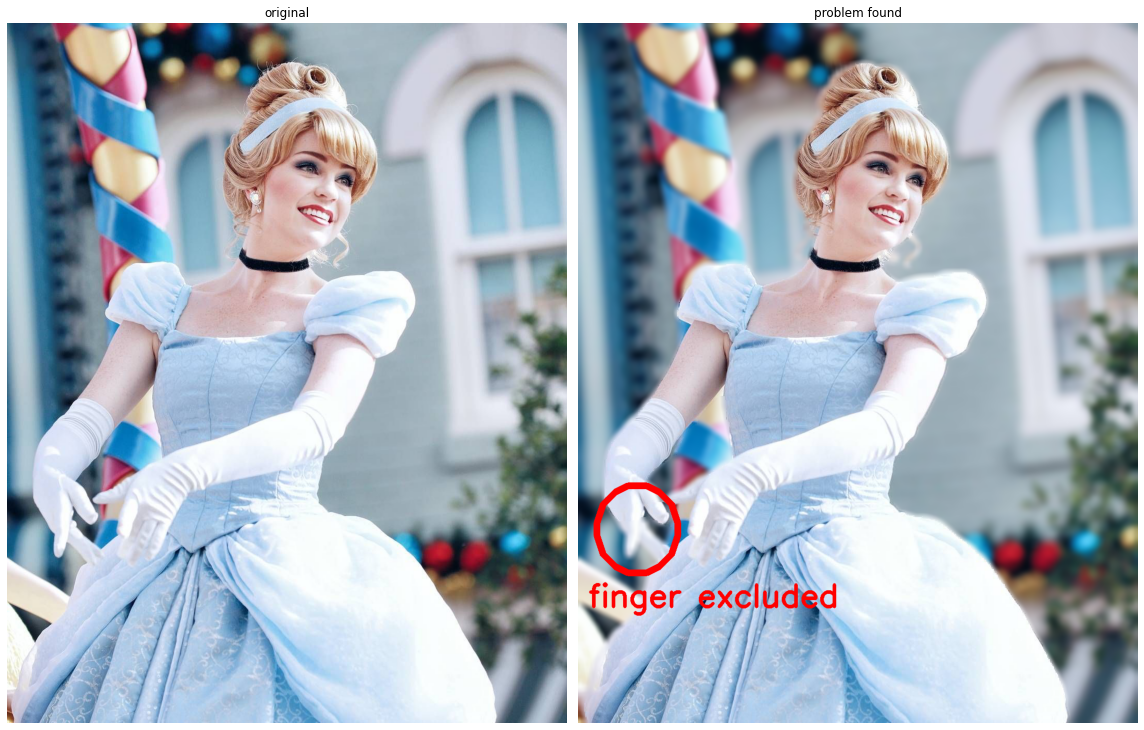

In [10]:
# problem in experiment with "image2.png"
img_original = test_img["img_rgb"][1]
img_merged = test_img["img_blurred"][1]
img_captioned = putCaption(img_merged, "finger excluded", (0, 1060), (20, 1125))
    
display2(img_original, img_merged, img_captioned)

**문 제 점** : 손가락 끝부분이 "person" 오브젝트로 인식되지 못하고 잘려나갔다 😭 오브젝트로 인식된 팔/손등(장갑 낀 부분) 부분과 유사한 색상의 픽셀인데도 불구하고 동일한 오브젝트로 인식하지 못하고 잘라낸 부분이 아쉽다.  
**해결방안** : 1차적으로 오브젝트를 인식한 후, 2차적을 오브젝트 경계 부분에 유사한 픽셀이 있다면 오브젝트 영역을 확장시키는 아이디어는 어떨까 생각한다. 다만 이러한 경우에는 오브젝트와 배경의 색상이 유사한 경우에는 segmentation이 어려워질 것이다. 해당 사진 또한 드레스와 배경 건물의 색이 하늘색으로 유사한데, 유사한 색상을 감지하는 threshold 값에 따라 오히려 드레스-건물이 같은 오브젝트로 인식되는 상황도 발생할 수 있다. 

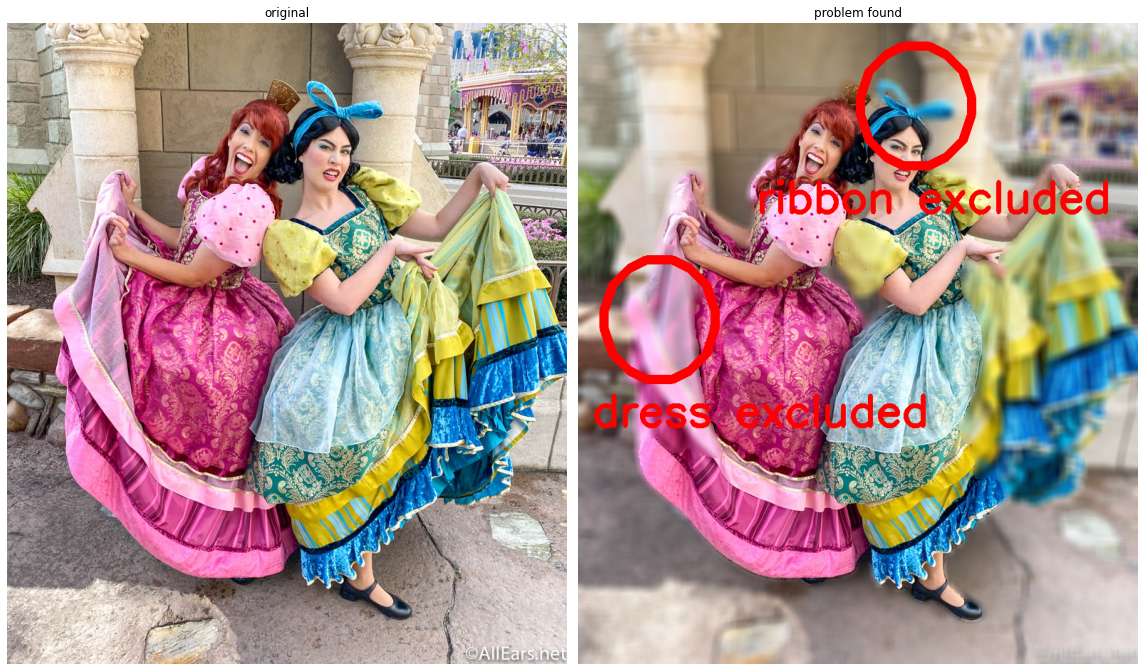

In [11]:
# problem in experiment with "image3.png"
img_original = test_img["img_rgb"][2]
img_merged = test_img["img_blurred"][2]
img_captioned = putCaption(img_merged, "dress excluded", (0, 500), (20, 565))
img_captioned = putCaption(img_captioned, "ribbon excluded", (360, 200), (250, 265))
    
display2(img_original, img_merged, img_captioned)

**문 제 점** : 드레스의 일부분과 머리 장식의 리본이 오브젝트로 인식되지 못하고 잘려나갔다 😭 오브젝트로 인식된 일부 드레스/리본 장식과 유사한 색상의 픽셀인데도 불구하고 동일한 오브젝트로 인식하지 못하고 잘라낸 부분이 아쉽다. 아마 segmentation model이 사람 오브젝트를 인식하는 task에서 이런 특수한 착장에 대한 경우는 미처 학습하지 못한 것 같다. 팔다리 형체가 잘 드러나지 않는 더욱 특이한 코스튬을 입었다면 사람으로도 인식되지 못했을 것이다... 😭  
**해결방안** : 1차적으로 오브젝트를 인식한 후, 2차적을 오브젝트 경계 부분에 유사한 픽셀이 있다면 오브젝트 영역을 확장시키는 아이디어는 어떨까 생각한다. 또는 특별한 착장에 대한 별도의 학습된 segmentation model을 적용하면 어떨까 생각한다.

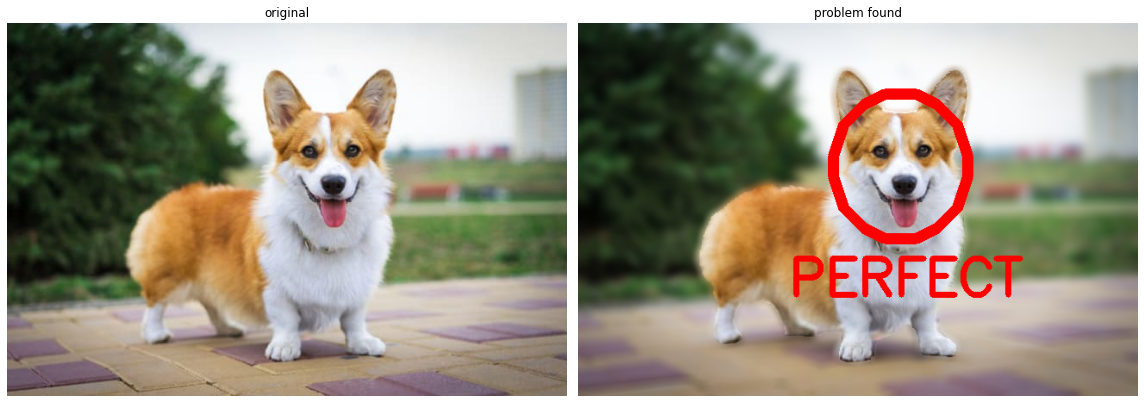

In [12]:
# problem in experiment with "image4.png"
img_original = test_img["img_rgb"][3]
img_merged = test_img["img_blurred"][3]
img_captioned = putCaption(img_merged, "PERFECT", (260, 250), (245, 315))
    
display2(img_original, img_merged, img_captioned)

**문 제 점** : 완벽 그 자체! 털/배경의 경계 부분이 잘 표현되지 못한 것이 아쉽지만, 포토샵 수작업으로도 쉽지 않은 부분이니 일단 만족스럽다 😙💕  
**해결방안** : 동물 오브젝트 같은 경우에는 털의 경계를 표현하기가 어려우므로, (몸통 핵심 부분) + (털 경계 부분) + (배경 부분) 이렇게 3군데로 나누어, 배경 부분은 KERNEL_SIZE 만큼 blur 처리 하고, 털 경계 부분에는 KERNEL_SIZE/3 정도 수준의 약한 blur를 하면 털의 질감을 잘 표현할 수 있을 것 같다.

---
**회고록**  
사진으로부터 자동으로 오브젝트를 구분해내는 segmentation 실습은 너무 재미있었다.  
이번에 실습한 Pascal Voc 는 21가지 오브젝트에 대응하였는데, 다른 다양한/특이한 오브젝트에 대응하는 학습 모델도 배우고싶다!!  


아직 CV에 대한 기반 지식이 없어서, 문제점을 지적하고 해결방안을 제시하는 것이 쉽지 않았다.  
segmentation이 제대로 되지 않거나 한계점을 갖고있는 부분이 많았는데, 세상에는 다양한 상황이 있고 이것을 일일이 인간의 언어로 다 정의할 수 없으니 당연히 한계가 있을 수 밖에 없고 생각한다.  
다만 조금이나마 더 나은 기술을 위해선 나도 끊임없이 공부하고 탐구해야겠다 🥸